## 0. 구글 드라이브와 연결 및 각종 라이브러리 다운로드

In [9]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [10]:
!pip install nltk

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [11]:
!pip install konlpy

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [12]:
from konlpy.tag import Okt
from tqdm import tqdm
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

In [13]:
import nltk

nltk.download()

# 이거 안하면 lookuperror 뜬다.(필요한 것만 지정해서 다운로드 해도되고, all을 사용하여 모두 다운로드 해도 된다.)

NLTK Downloader
---------------------------------------------------------------------------
    d) Download   l) List    u) Update   c) Config   h) Help   q) Quit
---------------------------------------------------------------------------
Downloader> d

Download which package (l=list; x=cancel)?
  Identifier> all


       | 
       | Downloading package abc to /root/nltk_data...
       |   Package abc is already up-to-date!
       | Downloading package alpino to /root/nltk_data...
       |   Package alpino is already up-to-date!
       | Downloading package averaged_perceptron_tagger to
       |     /root/nltk_data...
       |   Package averaged_perceptron_tagger is already up-to-date!
       | Downloading package averaged_perceptron_tagger_ru to
       |     /root/nltk_data...
       |   Package averaged_perceptron_tagger_ru is already up-to-
       |       date!
       | Downloading package basque_grammars to /root/nltk_data...
       |   Package basque_grammars is already up-to-date!
       | Downloading package biocreative_ppi to /root/nltk_data...
       |   Package biocreative_ppi is already up-to-date!
       | Downloading package bllip_wsj_no_aux to /root/nltk_data...
       |   Package bllip_wsj_no_aux is already up-to-date!
       | Downloading package book_grammars to /root/nltk_data..


---------------------------------------------------------------------------
    d) Download   l) List    u) Update   c) Config   h) Help   q) Quit
---------------------------------------------------------------------------
Downloader> q


True

## 1. 데이터 로드

In [14]:
import pandas as pd
import numpy as np

In [15]:
train_emotion_data = pd.read_excel('/content/gdrive/MyDrive/CUAI 하계 컨퍼런스 프로젝트/data set/감성대화말뭉치(최종데이터)_Training.xlsx', engine='openpyxl')

In [16]:
train_emotion_data.head(2)

,번호,연령,성별,상황키워드,신체질환,감정_대분류,감정_소분류,사람문장1,시스템응답1,사람문장2,시스템응답2,사람문장3,시스템응답3,사람문장4,시스템응답4
0,44164,청년,남성,"연애, 결혼, 출산",해당없음,기쁨,신이 난,아내가 드디어 출산하게 되어서 정말 신이 나.,아내분이 출산을 하시는군요. 정말 축하드려요.,아 지금 정말 신이 나.,잘 된 일이네요.,아기가 점점 클게 벌써 기대가 되네. 내가 많이 놀아줘야지.,좋은 아빠가 되실 거 같아요. 진심으로 축하드려요.,NaN,NaN
1,3926,노년,남성,"건강, 죽음",만성질환 유,불안,스트레스 받는,당뇨랑 합병증 때문에 먹어야 할 약이 열 가지가 넘어가니까 스트레스야.,약 종류가 많아 번거로우시겠어요.,건강할 때 관리 좀 잘할걸 하는 생각이 들더라고.,현재 상황에서 변화를 주기 위해 어떻게 하면 될까요?,약을 잘 챙겨 먹고 나을 수 있도록 노력해야지.,약을 잘 챙겨 먹어 건강해지시길 바랄게요.,NaN,NaN


In [17]:
validation_emotion_data = pd.read_excel('/content/gdrive/MyDrive/CUAI 하계 컨퍼런스 프로젝트/data set/감성대화말뭉치(최종데이터)_Validation.xlsx', engine='openpyxl')

In [18]:
validation_emotion_data.head(2)

,번호,연령,성별,상황키워드,신체질환,감정_대분류,감정_소분류,사람문장1,시스템응답1,사람문장2,시스템응답2,사람문장3,시스템응답3,사람문장4,시스템응답4
0,23093,청년,여성,"진로, 취업, 직장",해당없음,분노,툴툴대는,요즘 부모님과 많이 부딪혀.,어떤 일로 부딪히시나요?,난 하고 싶은 일이 있는데 부모님은 안정적인 일만 하라고 하셔. 내 마음대로 하지도...,부모님과의 충돌로 힘드시겠군요.,응. 그래도 난 내가 하고 싶은 일을 위해 노력할 거야.,자신이 하고 싶은 일을 목표로 하기로 하셨군요.,NaN,NaN
1,32848,청소년,남성,가족관계,해당없음,슬픔,비통한,엄마가 결국 집을 나갔어. 너무 너무 슬퍼.,어머니께서 집을 나가셨다니 정말 슬프셨겠어요. 좀 더 자세히 얘기해주시겠어요?,엄마도 엄마만의 인생이 있을 테니 가지 말라고 할 수가 없었어. 그래서 더 마음이 ...,정말 많이 답답하셨겠어요. 어떻게 하는 게 기분이 좀 풀릴까요?,일단 좀 자야겠어.,일단 휴식을 가질 생각이시군요.,NaN,NaN


In [19]:
nsmc_data = pd.read_csv('/content/gdrive/MyDrive/CUAI 하계 컨퍼런스 프로젝트/data set/nsmc_data.txt', sep='\t').dropna(axis=0)
nsmc_data.drop_duplicates(subset=['document'], inplace=True)

In [20]:
nsmc_data.head(2)

,id,document,label
0,8112052,어릴때보고 지금다시봐도 재밌어요ㅋㅋ,1
1,8132799,"디자인을 배우는 학생으로, 외국디자이너와 그들이 일군 전통을 통해 발전해가는 문화산...",1


In [21]:
print('train_emotion_data의 sample의 수: {}개'.format(train_emotion_data.shape[0]))
print('validation_emotion_data의 sample의 수: {}개'.format(validation_emotion_data.shape[0]))
print('nsmc_data의 sample의 수: {}개'.format(nsmc_data.shape[0]))
print('모든 샘플의 수: {}개'.format(train_emotion_data.shape[0]+validation_emotion_data.shape[0]+nsmc_data.shape[0]))

train_emotion_data의 sample의 수: 40879개
validation_emotion_data의 sample의 수: 5130개
nsmc_data의 sample의 수: 194543개
모든 샘플의 수: 240552개


## 2. 데이터 정제

### nsmc data 전처리

* nsmc data 중복 값 처리

In [22]:
nsmc_data['document'].nunique(), nsmc_data['label'].nunique()

# 중복된 값이 없다.

(194543, 2)

* nsmc data의 레이블 값의 분포 확인

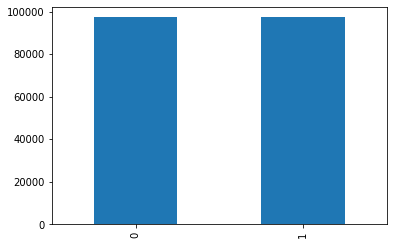

In [23]:
nsmc_data['label'].value_counts().plot.bar()

In [24]:
print('label 0의 수: {}'.format(nsmc_data['label'].value_counts()[0]))
print('label 1의 수: {}'.format(nsmc_data['label'].value_counts()[1]))

label 0의 수: 97277
label 1의 수: 97266


* nsmc data의 NULL 값 처리

In [25]:
nsmc_data.isnull().sum(axis=0)

# NULL 값이 없다.

id          0
document    0
label       0
dtype: int64

* nsmc data의 노이즈 제거

In [26]:
nsmc_data['document'] = nsmc_data['document'].str.replace("[^ 가-힣]", "", regex=True)

# 공백과 한국어가 아닌 것은 제거한다.(단, 'ㅋ'같은 것들은 제거)


In [27]:
nsmc_data.head()

,id,document,label
0,8112052,어릴때보고 지금다시봐도 재밌어요,1
1,8132799,디자인을 배우는 학생으로 외국디자이너와 그들이 일군 전통을 통해 발전해가는 문화산업...,1
2,4655635,폴리스스토리 시리즈는 부터 뉴까지 버릴께 하나도 없음 최고,1
3,9251303,와 연기가 진짜 개쩔구나 지루할거라고 생각했는데 몰입해서 봤다 그래 이런게 진짜 영화지,1
4,10067386,안개 자욱한 밤하늘에 떠 있는 초승달 같은 영화,1


In [28]:
nsmc_data.isnull().sum(axis=0)

# 노이즈를 제거 하였으므로 NULL 데이터가 생겼을 수도 있다.
# 그러나 이 경우 NULL 데이터가 생기지 않았다.

id          0
document    0
label       0
dtype: int64

In [29]:
df_1 = nsmc_data[['document', 'label']]
df_1

,document,label
0,어릴때보고 지금다시봐도 재밌어요,1
1,디자인을 배우는 학생으로 외국디자이너와 그들이 일군 전통을 통해 발전해가는 문화산업...,1
2,폴리스스토리 시리즈는 부터 뉴까지 버릴께 하나도 없음 최고,1
3,와 연기가 진짜 개쩔구나 지루할거라고 생각했는데 몰입해서 봤다 그래 이런게 진짜 영화지,1
4,안개 자욱한 밤하늘에 떠 있는 초승달 같은 영화,1
...,...,...
199995,포켓 몬스터 짜가,0
199996,쓰레기,0
199997,완전 사이코영화 마지막은 더욱더 이 영화의질을 떨어트린다,0
199998,왜난 재미없었지 라따뚜이 보고나서 스머프 봐서 그런가,0


### train emotion data 전처리

In [109]:
train_emotion_data['감정_대분류'].value_counts()

불안     7328
분노     6920
슬픔     6915
기쁨     6730
상처     6624
당황     6360
불안        1
기쁨        1
Name: 감정_대분류, dtype: int64

In [110]:
train_emotion_data = train_emotion_data[['감정_대분류', '사람문장1', '사람문장2']]

In [111]:
train_emotion_data['label'] = 0
train_emotion_data.loc[train_emotion_data['감정_대분류']=='기쁨', 'label'] = 1

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)


* train emotion data의 중복된 값 전처리

In [113]:
train_emotion_data.shape

(40879, 4)

In [115]:
train_emotion_data['사람문장1'].nunique(), train_emotion_data['사람문장2'].nunique(), train_emotion_data['label'].nunique()

# '사람문장1'과 '사람문장2'에 중복된 값이 있는 것을 알 수 있다.

(39415, 38878, 2)

In [120]:
train_emotion_data.drop_duplicates(subset=['사람문장1'], inplace=True, ignore_index=True)
train_emotion_data.drop_duplicates(subset=['사람문장2'], inplace=True, ignore_index=True)

In [124]:
train_emotion_data.shape[0], train_emotion_data['사람문장1'].nunique(), train_emotion_data['사람문장2'].nunique(), train_emotion_data['label'].nunique()

# 중복된 것이 사라진 것을 볼 수 있다.

(38713, 38713, 38713, 2)

In [125]:
train_emotion_data

,감정_대분류,사람문장1,사람문장2,label
0,기쁨,아내가 드디어 출산하게 되어서 정말 신이 나.,아 지금 정말 신이 나.,1
1,불안,당뇨랑 합병증 때문에 먹어야 할 약이 열 가지가 넘어가니까 스트레스야.,건강할 때 관리 좀 잘할걸 하는 생각이 들더라고.,0
2,당황,고등학교에 올라오니 중학교 때보다 수업이 갑자기 어려워져서 당황스러워.,아직 학기 초인데 내가 수업에 잘 따라갈 수 있을지 걱정돼.,0
3,기쁨,재취업이 돼서 받게 된 첫 월급으로 온 가족이 외식을 할 예정이야. 너무 행복해.,퇴직 후 다시는 돈을 못 벌 줄 알았는데 이렇게 월급으로 가족에게 맛있는 밥을 살 ...,1
4,기쁨,빚을 드디어 다 갚게 되어서 이제야 안도감이 들어.,빚도 다 갚았으니 당분간은 아무 생각도 안 하며 살고 싶어.,1
...,...,...,...,...
38708,상처,최 영감이 노인들에게 나를 이상한 사람으로 이야기해서 답답하고 억울해.,최 영감은 나를 늘 질투하는 것 같아.,0
38709,기쁨,지난주에 건강검진 결과가 나왔는데 정상이라고 결과가 나왔어.,결과가 좋게 나와서 다행이야,1
38710,슬픔,엄마는 내 꿈인 작가를 응원해 주고는 했는데 지금은 안 그래. 너무 슬퍼.,내 재능이 남들보다 월등한 거는 아니라면서 취업해서 안정적으로 살았으면 좋겠다고 하셔.,0
38711,기쁨,이렇게 좋은 운동 시설에서 경로 우대로 운동할 수 있다니 참 행운이야.,덕분에 건강도 챙길 수 있고 너무 좋아. 안마기도 있던데 내일은 운동하고 안마기도 ...,1


In [126]:
train_sent_1 = train_emotion_data[['사람문장1', 'label']]
train_sent_2 = train_emotion_data[['사람문장2', 'label']]

In [129]:
train_sent_1['nsent']=0
train_sent_2['nsent']=0

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [136]:
from nltk.tokenize import sent_tokenize

In [141]:
len(sent_tokenize('안녕. 나는 오창준이야'))

2

In [142]:
train_sent_1['nsent'] = train_sent_1['사람문장1'].map(sent_tokenize).map(len)
train_sent_2['nsent'] = train_sent_2['사람문장2'].map(sent_tokenize).map(len)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [146]:
train_sent_1['nsent'].value_counts()

1    28421
2    10033
3      239
4       20
Name: nsent, dtype: int64

In [147]:
train_sent_2['nsent'].value_counts()

1    24254
2    13612
3      779
4       58
5        9
6        1
Name: nsent, dtype: int64

In [156]:
train_sent_1.loc[train_sent_1['nsent']==2].head(50)

# 문장이 2개인 경우, 보통 '감정 + 그 이유'의 형식을 갖고 있다.
# 즉, 문장이 2개인 경우는 분리해서 사용하면 될듯
# 물론 위와 같은 형식이 아닌 경우도 존재한다. 직접 지워줄 수 있는대로 지워주자

# dataframe을 넣으면 모든 문장을 쪼갠 dataframe을 반환하는 함수를 만들면 좋을듯

,사람문장1,label,nsent
3,재취업이 돼서 받게 된 첫 월급으로 온 가족이 외식을 할 예정이야. 너무 행복해.,1,2
8,친구들이 나를 괴롭혀. 부모님과 선생님께 얘기했는데도 믿어주지 않아.,0,2
10,새로 간 치과에서 조금 썩기만 한 이를 임플란트를 하라고 했어. 과잉진료는 안 한다더니.,0,2
13,아내의 건강이 갑자기 악화됐어. 너무 걱정스럽고 불안해.,0,2
16,이번에도 고시에 불합격했어. 부모님께 무슨 소리를 들을지 벌써부터 두려워.,0,2
20,지난주에 주식이 폭락해서 너무 큰 손해를 봤어. 어떻게 해야 좋을지 모르겠고 정신이...,0,2
27,빨리 정년퇴직하고 공기 좋은 시골로 내려가서 살고 싶어. 도시는 너무 답답하고 힘들어.,0,2
29,남편이 내 돈을 들고 집을 나갔어. 어떡하지?,0,2
32,난 아주 성실하게 살아왔다고 자신하지만 주변에 남은 이가 아무도 없어. 공허함에 눈...,0,2
34,나이가 많다고 이번 프로젝트를 맡지 못했어. 정말 화가 나.,0,2


In [157]:
train_sent_1.loc[train_sent_1['nsent']==3].head(50)

,사람문장1,label,nsent
90,정년퇴직을 하게 되었어. 노후 준비를 다 해놔서 그런지 두렵지 않아. 너무 기뻐.,1,3
95,요즘 내 진로에 대해서 고민이 많아. 명확한 꿈이 없어. 혼란스러워.,0,3
187,오빠는 일이 없나 봐. 항상 혼자 방에 틀어박혀 있어. 그런 오빠가 좀 걱정돼.,0,3
368,항상 피로감은 있었지만 간암일 줄이야. 병원에서 죽을 수도 있다는데 참혹하고 화가 ...,0,3
636,내 주위에 괴롭힘을 당하는 친구가 있어. 분명 나에게 도움을 청할 거야. 난 그렇게...,1,3
783,교통사고가 나서 다리를 잃었어. 이대로 사는 건 아무 의미가 없는 것 같아. 세상이...,0,3
869,오늘 회사에서 잘못을 지적당했어. 근데 난 이해할 수가 없어. 내가 옳은 것 같아.,0,3
1213,어제 엄마한테 엄마가 뭘 아냐고 소리 지른 게 너무 후회돼. 엄마가 상처받았을 것 ...,0,3
1220,내가 이렇게 아픈데 아무도 나에게 관심이 없어. 자식들마저 자기들 살기 바빠. 너무...,0,3
1222,회사 생활이 너무 힘들어. 정말 출근하기 싫다. 인간관계가 이렇게 힘들 줄 몰랐어.,0,3


In [158]:
train_sent_1.loc[train_sent_1['nsent']==4].head(20)

,사람문장1,label,nsent
5,이제 곧 은퇴할 시기가 되었어. 내가 먼저 은퇴를 하고 육 개월 후에 남편도 은퇴를...,0,4
729,취업 준비만 삼 년째야. 아주 지겹고 이제는 의지도 안 생겨. 평생 백수로 놀고먹는...,0,4
1979,아내가 방귀를 뀌고 그것을 손으로 가져다 내 얼굴에 뿌렸어. 그런 행동은 정말 안 ...,0,4
5592,남편이 생활비 쓰는 걸 확인하겠대. 신경질 나. 이 나이에 검사를 맡게 생겼어! 스...,0,4
8724,요새 회사에서 계속 야근하니까 너무 힘들어. 일을 해도 해도 안 끝나는 것 같아. ...,0,4
11433,영업팀 김 부장이 어제 뇌출혈로 쓰러졌대. 이제 겨우 오십인데. 김 부장 보니 나도...,0,4
16184,아 결국 친구한테 빌려준 돈을 떼이게 생겼어. 급전이 필요하다고 부탁해서 여러차례 ...,0,4
17373,이 나이 먹도록 남은 게 아무것도 없어. 이제까지 부모님 뒷바라지만 하다 보니 내 ...,0,4
18467,애들이 자꾸 나를 무시하고 어울리기 싫어해. 내가 말 거는 것조차 싫어하는 것 같아...,0,4
20482,친구에게 퇴직금 받은 걸 빌려줬는데. 몇 달째 연락이 안 돼. 나 어떻게 하지? 살...,0,4


In [160]:
train_sent_1.loc[train_sent_1['nsent']==2].to_excel('/content/gdrive/MyDrive/CUAI 하계 컨퍼런스 프로젝트/data preprocessing/train_1_2.xlsx')

In [161]:
train_sent_1.loc[train_sent_1['nsent']==3].to_excel('/content/gdrive/MyDrive/CUAI 하계 컨퍼런스 프로젝트/data preprocessing/train_1_3.xlsx')

In [162]:
train_sent_1.loc[train_sent_1['nsent']==4].to_excel('/content/gdrive/MyDrive/CUAI 하계 컨퍼런스 프로젝트/data preprocessing/train_1_4.xlsx')

In [111]:
# 2개 이상의 문장을 갖는 데이터를 삭제할지 혹은 하나하나 손볼지 결정해야 할듯

In [163]:
train_sent_1.loc[train_sent_1['nsent']<=2]

,사람문장1,label,nsent
0,아내가 드디어 출산하게 되어서 정말 신이 나.,1,1
1,당뇨랑 합병증 때문에 먹어야 할 약이 열 가지가 넘어가니까 스트레스야.,0,1
2,고등학교에 올라오니 중학교 때보다 수업이 갑자기 어려워져서 당황스러워.,0,1
3,재취업이 돼서 받게 된 첫 월급으로 온 가족이 외식을 할 예정이야. 너무 행복해.,1,2
4,빚을 드디어 다 갚게 되어서 이제야 안도감이 들어.,1,1
...,...,...,...
38708,최 영감이 노인들에게 나를 이상한 사람으로 이야기해서 답답하고 억울해.,0,1
38709,지난주에 건강검진 결과가 나왔는데 정상이라고 결과가 나왔어.,1,1
38710,엄마는 내 꿈인 작가를 응원해 주고는 했는데 지금은 안 그래. 너무 슬퍼.,0,2
38711,이렇게 좋은 운동 시설에서 경로 우대로 운동할 수 있다니 참 행운이야.,1,1


In [164]:
train_sent_1.columns = ['document', 'label', 'nsent']
train_sent_2.columns = ['document', 'label', 'nsent']

In [165]:
train_sent_1

,document,label,nsent
0,아내가 드디어 출산하게 되어서 정말 신이 나.,1,1
1,당뇨랑 합병증 때문에 먹어야 할 약이 열 가지가 넘어가니까 스트레스야.,0,1
2,고등학교에 올라오니 중학교 때보다 수업이 갑자기 어려워져서 당황스러워.,0,1
3,재취업이 돼서 받게 된 첫 월급으로 온 가족이 외식을 할 예정이야. 너무 행복해.,1,2
4,빚을 드디어 다 갚게 되어서 이제야 안도감이 들어.,1,1
...,...,...,...
38708,최 영감이 노인들에게 나를 이상한 사람으로 이야기해서 답답하고 억울해.,0,1
38709,지난주에 건강검진 결과가 나왔는데 정상이라고 결과가 나왔어.,1,1
38710,엄마는 내 꿈인 작가를 응원해 주고는 했는데 지금은 안 그래. 너무 슬퍼.,0,2
38711,이렇게 좋은 운동 시설에서 경로 우대로 운동할 수 있다니 참 행운이야.,1,1


In [192]:
def trans_df(df):
  temp = pd.DataFrame({'document':[], 'label':[]})
  num = 0
  for i in range(df.shape[0]):
    if(i%10000 == 0):
      print(i,'번째')
    for s in sent_tokenize(df['document'][i]):
      temp.loc[num] = [s, df['label'][i]]
      num = num+1
  return temp

In [193]:
d1 = trans_df(train_sent_1)

0 번째
10000 번째
20000 번째
30000 번째


In [194]:
d2 = trans_df(train_sent_2)

0 번째
10000 번째
20000 번째
30000 번째


In [195]:
d1

,document,label
0,아내가 드디어 출산하게 되어서 정말 신이 나.,1.0
1,당뇨랑 합병증 때문에 먹어야 할 약이 열 가지가 넘어가니까 스트레스야.,0.0
2,고등학교에 올라오니 중학교 때보다 수업이 갑자기 어려워져서 당황스러워.,0.0
3,재취업이 돼서 받게 된 첫 월급으로 온 가족이 외식을 할 예정이야.,1.0
4,너무 행복해.,1.0
...,...,...
49279,엄마는 내 꿈인 작가를 응원해 주고는 했는데 지금은 안 그래.,0.0
49280,너무 슬퍼.,0.0
49281,이렇게 좋은 운동 시설에서 경로 우대로 운동할 수 있다니 참 행운이야.,1.0
49282,친구 관계가 너무 힘들어.,0.0


In [196]:
d2

,document,label
0,아 지금 정말 신이 나.,1.0
1,건강할 때 관리 좀 잘할걸 하는 생각이 들더라고.,0.0
2,아직 학기 초인데 내가 수업에 잘 따라갈 수 있을지 걱정돼.,0.0
3,퇴직 후 다시는 돈을 못 벌 줄 알았는데 이렇게 월급으로 가족에게 맛있는 밥을 살 ...,1.0
4,빚도 다 갚았으니 당분간은 아무 생각도 안 하며 살고 싶어.,1.0
...,...,...
54093,결과가 좋게 나와서 다행이야,1.0
54094,내 재능이 남들보다 월등한 거는 아니라면서 취업해서 안정적으로 살았으면 좋겠다고 하셔.,0.0
54095,덕분에 건강도 챙길 수 있고 너무 좋아.,1.0
54096,안마기도 있던데 내일은 운동하고 안마기도 써볼까?,1.0


In [197]:
d3 = d1.append(d2, ignore_index=True)
d3

,document,label
0,아내가 드디어 출산하게 되어서 정말 신이 나.,1.0
1,당뇨랑 합병증 때문에 먹어야 할 약이 열 가지가 넘어가니까 스트레스야.,0.0
2,고등학교에 올라오니 중학교 때보다 수업이 갑자기 어려워져서 당황스러워.,0.0
3,재취업이 돼서 받게 된 첫 월급으로 온 가족이 외식을 할 예정이야.,1.0
4,너무 행복해.,1.0
...,...,...
103377,결과가 좋게 나와서 다행이야,1.0
103378,내 재능이 남들보다 월등한 거는 아니라면서 취업해서 안정적으로 살았으면 좋겠다고 하셔.,0.0
103379,덕분에 건강도 챙길 수 있고 너무 좋아.,1.0
103380,안마기도 있던데 내일은 운동하고 안마기도 써볼까?,1.0


In [200]:
d3['label'] = d3['label'].astype('int64')
d3

,document,label
0,아내가 드디어 출산하게 되어서 정말 신이 나.,1
1,당뇨랑 합병증 때문에 먹어야 할 약이 열 가지가 넘어가니까 스트레스야.,0
2,고등학교에 올라오니 중학교 때보다 수업이 갑자기 어려워져서 당황스러워.,0
3,재취업이 돼서 받게 된 첫 월급으로 온 가족이 외식을 할 예정이야.,1
4,너무 행복해.,1
...,...,...
103377,결과가 좋게 나와서 다행이야,1
103378,내 재능이 남들보다 월등한 거는 아니라면서 취업해서 안정적으로 살았으면 좋겠다고 하셔.,0
103379,덕분에 건강도 챙길 수 있고 너무 좋아.,1
103380,안마기도 있던데 내일은 운동하고 안마기도 써볼까?,1


In [201]:
d3.to_excel('/content/gdrive/MyDrive/CUAI 하계 컨퍼런스 프로젝트/data preprocessing/train_1.xlsx')

In [204]:
train_data = pd.read_excel('/content/gdrive/MyDrive/CUAI 하계 컨퍼런스 프로젝트/data preprocessing/train_1.xlsx', engine='openpyxl')

In [209]:
train_data = train_data[['document', 'label']]
train_data

,document,label
0,아내가 드디어 출산하게 되어서 정말 신이 나.,1
1,당뇨랑 합병증 때문에 먹어야 할 약이 열 가지가 넘어가니까 스트레스야.,0
2,고등학교에 올라오니 중학교 때보다 수업이 갑자기 어려워져서 당황스러워.,0
3,재취업이 돼서 받게 된 첫 월급으로 온 가족이 외식을 할 예정이야.,1
4,너무 행복해.,1
...,...,...
103377,결과가 좋게 나와서 다행이야,1
103378,내 재능이 남들보다 월등한 거는 아니라면서 취업해서 안정적으로 살았으면 좋겠다고 하셔.,0
103379,덕분에 건강도 챙길 수 있고 너무 좋아.,1
103380,안마기도 있던데 내일은 운동하고 안마기도 써볼까?,1


In [210]:
train_data['document'] = train_data['document'].str.replace("[^ 가-힣]", "", regex=True)

In [215]:
df_2 = train_data
df_2['document'].isnull().sum()

0

In [213]:
df_2

,document,label
0,아내가 드디어 출산하게 되어서 정말 신이 나,1
1,당뇨랑 합병증 때문에 먹어야 할 약이 열 가지가 넘어가니까 스트레스야,0
2,고등학교에 올라오니 중학교 때보다 수업이 갑자기 어려워져서 당황스러워,0
3,재취업이 돼서 받게 된 첫 월급으로 온 가족이 외식을 할 예정이야,1
4,너무 행복해,1
...,...,...
103377,결과가 좋게 나와서 다행이야,1
103378,내 재능이 남들보다 월등한 거는 아니라면서 취업해서 안정적으로 살았으면 좋겠다고 하셔,0
103379,덕분에 건강도 챙길 수 있고 너무 좋아,1
103380,안마기도 있던데 내일은 운동하고 안마기도 써볼까,1


In [216]:
data = df_1.append(df_2, ignore_index=True)
data

,document,label
0,어릴때보고 지금다시봐도 재밌어요,1
1,디자인을 배우는 학생으로 외국디자이너와 그들이 일군 전통을 통해 발전해가는 문화산업...,1
2,폴리스스토리 시리즈는 부터 뉴까지 버릴께 하나도 없음 최고,1
3,와 연기가 진짜 개쩔구나 지루할거라고 생각했는데 몰입해서 봤다 그래 이런게 진짜 영화지,1
4,안개 자욱한 밤하늘에 떠 있는 초승달 같은 영화,1
...,...,...
297920,결과가 좋게 나와서 다행이야,1
297921,내 재능이 남들보다 월등한 거는 아니라면서 취업해서 안정적으로 살았으면 좋겠다고 하셔,0
297922,덕분에 건강도 챙길 수 있고 너무 좋아,1
297923,안마기도 있던데 내일은 운동하고 안마기도 써볼까,1


### validation emtion data 전처리

In [218]:
validation_emotion_data.head(2)

,번호,연령,성별,상황키워드,신체질환,감정_대분류,감정_소분류,사람문장1,시스템응답1,사람문장2,시스템응답2,사람문장3,시스템응답3,사람문장4,시스템응답4
0,23093,청년,여성,"진로, 취업, 직장",해당없음,분노,툴툴대는,요즘 부모님과 많이 부딪혀.,어떤 일로 부딪히시나요?,난 하고 싶은 일이 있는데 부모님은 안정적인 일만 하라고 하셔. 내 마음대로 하지도...,부모님과의 충돌로 힘드시겠군요.,응. 그래도 난 내가 하고 싶은 일을 위해 노력할 거야.,자신이 하고 싶은 일을 목표로 하기로 하셨군요.,NaN,NaN
1,32848,청소년,남성,가족관계,해당없음,슬픔,비통한,엄마가 결국 집을 나갔어. 너무 너무 슬퍼.,어머니께서 집을 나가셨다니 정말 슬프셨겠어요. 좀 더 자세히 얘기해주시겠어요?,엄마도 엄마만의 인생이 있을 테니 가지 말라고 할 수가 없었어. 그래서 더 마음이 ...,정말 많이 답답하셨겠어요. 어떻게 하는 게 기분이 좀 풀릴까요?,일단 좀 자야겠어.,일단 휴식을 가질 생각이시군요.,NaN,NaN


In [219]:
validation_emotion_data['감정_대분류'].value_counts()

불안    907
분노    873
슬픔    861
기쁨    841
당황    832
상처    816
Name: 감정_대분류, dtype: int64

In [220]:
validation_emotion_data.shape

(5130, 15)

In [221]:
validation_emotion_data = validation_emotion_data[['감정_대분류', '사람문장1', '사람문장2']]
validation_emotion_data

,감정_대분류,사람문장1,사람문장2
0,분노,요즘 부모님과 많이 부딪혀.,난 하고 싶은 일이 있는데 부모님은 안정적인 일만 하라고 하셔. 내 마음대로 하지도...
1,슬픔,엄마가 결국 집을 나갔어. 너무 너무 슬퍼.,엄마도 엄마만의 인생이 있을 테니 가지 말라고 할 수가 없었어. 그래서 더 마음이 ...
2,불안,학교에서 한 친구를 괴롭히는 무리에게 그만하라고 했어.,그런데 말을 하고 난 후 나도 괴롭힐까 봐 불안했어.
3,당황,이번에 팀장님이 간단한 조사 업무를 부탁하셨는데 내가 잘못 처리했어. 너무 절망적이야.,곧 있으면 인턴에서 정규직 전환 평가가 있는데 안 좋을 것 같아.
4,분노,남편이 이혼할 때 위자료를 주지 않으려고 변호사를 고용했어.,어떻게 그럴 수가 있지? 너무 화가 나.
...,...,...,...
5125,기쁨,부동산 임대 소득으로 현재 여유롭게 살 수 있어서 좋단다.,그래서 마음의 안정을 가질 수 있었던 것 같아.
5126,불안,폐결핵은 이미 완치된 것 같은데 약을 한 달이나 더 먹으라고 하네? 아직 안 나은 ...,이대로 혹시 더 심해져서 죽게 되는 건 아닐까?
5127,분노,연애하고 싶은데 소개팅만 나가면 꽝이야. 이러다가 난 결혼 못 하고 늙어 죽을 거야.,내가 게을러서 다른 방법을 아직 생각하진 못했어. 댄스 동호회는 좀 괜찮은 것 같은...
5128,분노,은행 대출이 막혀서 생활비를 구할 수가 없어. 이제 어떻게 살아야 하나 막막해.,당장 내일 밥은 어떡하고 내 병원비는 어쩌지.


In [223]:
validation_emotion_data['label'] = 0
validation_emotion_data.loc[validation_emotion_data['감정_대분류']=='기쁨', 'label'] = 1
validation_emotion_data

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)


,감정_대분류,사람문장1,사람문장2,label
0,분노,요즘 부모님과 많이 부딪혀.,난 하고 싶은 일이 있는데 부모님은 안정적인 일만 하라고 하셔. 내 마음대로 하지도...,0
1,슬픔,엄마가 결국 집을 나갔어. 너무 너무 슬퍼.,엄마도 엄마만의 인생이 있을 테니 가지 말라고 할 수가 없었어. 그래서 더 마음이 ...,0
2,불안,학교에서 한 친구를 괴롭히는 무리에게 그만하라고 했어.,그런데 말을 하고 난 후 나도 괴롭힐까 봐 불안했어.,0
3,당황,이번에 팀장님이 간단한 조사 업무를 부탁하셨는데 내가 잘못 처리했어. 너무 절망적이야.,곧 있으면 인턴에서 정규직 전환 평가가 있는데 안 좋을 것 같아.,0
4,분노,남편이 이혼할 때 위자료를 주지 않으려고 변호사를 고용했어.,어떻게 그럴 수가 있지? 너무 화가 나.,0
...,...,...,...,...
5125,기쁨,부동산 임대 소득으로 현재 여유롭게 살 수 있어서 좋단다.,그래서 마음의 안정을 가질 수 있었던 것 같아.,1
5126,불안,폐결핵은 이미 완치된 것 같은데 약을 한 달이나 더 먹으라고 하네? 아직 안 나은 ...,이대로 혹시 더 심해져서 죽게 되는 건 아닐까?,0
5127,분노,연애하고 싶은데 소개팅만 나가면 꽝이야. 이러다가 난 결혼 못 하고 늙어 죽을 거야.,내가 게을러서 다른 방법을 아직 생각하진 못했어. 댄스 동호회는 좀 괜찮은 것 같은...,0
5128,분노,은행 대출이 막혀서 생활비를 구할 수가 없어. 이제 어떻게 살아야 하나 막막해.,당장 내일 밥은 어떡하고 내 병원비는 어쩌지.,0


In [224]:
validation_data_1 = validation_emotion_data[['사람문장1', 'label']]
validation_data_2 = validation_emotion_data[['사람문장2', 'label']]

In [226]:
validation_data_2.shape

(5130, 2)

In [228]:
validation_data_1['사람문장1'].nunique(), validation_data_2['사람문장2'].nunique()

# 중복되는 것이 있다는 것을 알 수 있다.

(5103, 5096)

In [229]:
validation_data_1.drop_duplicates(subset=['사람문장1'], inplace=True, ignore_index=True)
validation_data_2.drop_duplicates(subset=['사람문장2'], inplace=True, ignore_index=True)

/usr/local/lib/python3.7/dist-packages/pandas/util/_decorators.py:311: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return func(*args, **kwargs)


In [230]:
validation_data_1['사람문장1'].nunique(), validation_data_2['사람문장2'].nunique()

(5103, 5096)

In [231]:
validation_data_1.shape, validation_data_2.shape

# 중복된 것을 삭제하였다.

((5103, 2), (5096, 2))

In [233]:
validation_data_1.head(10)

,사람문장1,label
0,요즘 부모님과 많이 부딪혀.,0
1,엄마가 결국 집을 나갔어. 너무 너무 슬퍼.,0
2,학교에서 한 친구를 괴롭히는 무리에게 그만하라고 했어.,0
3,이번에 팀장님이 간단한 조사 업무를 부탁하셨는데 내가 잘못 처리했어. 너무 절망적이야.,0
4,남편이 이혼할 때 위자료를 주지 않으려고 변호사를 고용했어.,0
5,친구들과 노후에 대한 이야기를 하다 보니 서로 노후 자금 차이가 상당히 컸어.,0
6,직장에서 모함을 받았어. 난 정말 억울해.,0
7,요즘 딸에게 뭔가 물어보면 신경질부터 내는데 화가 나.,0
8,언제까지 대출금을 갚으며 살아야 할까? 포기하고 싶어지고 너무 슬퍼.,0
9,이 업무는 하루 만에 끝낼 수 있을 것 같아.,1


In [234]:
validation_data_1.columns = ['document', 'label']
validation_data_2.columns = ['document', 'label']

In [235]:
d1 = trans_df(validation_data_1)
d2 = trans_df(validation_data_2)

0 번째
0 번째


In [236]:
d1

,document,label
0,요즘 부모님과 많이 부딪혀.,0.0
1,엄마가 결국 집을 나갔어.,0.0
2,너무 너무 슬퍼.,0.0
3,학교에서 한 친구를 괴롭히는 무리에게 그만하라고 했어.,0.0
4,이번에 팀장님이 간단한 조사 업무를 부탁하셨는데 내가 잘못 처리했어.,0.0
...,...,...
6434,이러다가 난 결혼 못 하고 늙어 죽을 거야.,0.0
6435,은행 대출이 막혀서 생활비를 구할 수가 없어.,0.0
6436,이제 어떻게 살아야 하나 막막해.,0.0
6437,자식들은 키워 준 은혜도 모르고 내게 오지도 않네.,0.0


In [237]:
d2

,document,label
0,난 하고 싶은 일이 있는데 부모님은 안정적인 일만 하라고 하셔.,0.0
1,내 마음대로 하지도 못해.,0.0
2,엄마도 엄마만의 인생이 있을 테니 가지 말라고 할 수가 없었어.,0.0
3,그래서 더 마음이 답답해.,0.0
4,그런데 말을 하고 난 후 나도 괴롭힐까 봐 불안했어.,0.0
...,...,...
7063,내가 게을러서 다른 방법을 아직 생각하진 못했어.,0.0
7064,댄스 동호회는 좀 괜찮은 것 같은데 이참에 가입해볼까?,0.0
7065,당장 내일 밥은 어떡하고 내 병원비는 어쩌지.,0.0
7066,응 이제 다들 독립해가지고 명절 아니면 찾아오질 않아.,0.0


In [238]:
d3 = d1.append(d2, ignore_index=True)

In [240]:
d3['label'] = d3['label'].astype('int64')

In [242]:
d3.to_excel('/content/gdrive/MyDrive/CUAI 하계 컨퍼런스 프로젝트/data preprocessing/train_2.xlsx')

In [243]:
df_3 = pd.read_excel('/content/gdrive/MyDrive/CUAI 하계 컨퍼런스 프로젝트/data preprocessing/train_2.xlsx', engine='openpyxl')
df_3 = df_3[['document', 'label']]
df_3

,document,label
0,요즘 부모님과 많이 부딪혀.,0
1,엄마가 결국 집을 나갔어.,0
2,너무 너무 슬퍼.,0
3,학교에서 한 친구를 괴롭히는 무리에게 그만하라고 했어.,0
4,이번에 팀장님이 간단한 조사 업무를 부탁하셨는데 내가 잘못 처리했어.,0
...,...,...
13502,내가 게을러서 다른 방법을 아직 생각하진 못했어.,0
13503,댄스 동호회는 좀 괜찮은 것 같은데 이참에 가입해볼까?,0
13504,당장 내일 밥은 어떡하고 내 병원비는 어쩌지.,0
13505,응 이제 다들 독립해가지고 명절 아니면 찾아오질 않아.,0


In [244]:
data = data.append(df_3, ignore_index=True)

In [247]:
data['document'] = data['document'].str.replace("[^ 가-힣]", "", regex=True)
data

,document,label
0,어릴때보고 지금다시봐도 재밌어요,1
1,디자인을 배우는 학생으로 외국디자이너와 그들이 일군 전통을 통해 발전해가는 문화산업...,1
2,폴리스스토리 시리즈는 부터 뉴까지 버릴께 하나도 없음 최고,1
3,와 연기가 진짜 개쩔구나 지루할거라고 생각했는데 몰입해서 봤다 그래 이런게 진짜 영화지,1
4,안개 자욱한 밤하늘에 떠 있는 초승달 같은 영화,1
...,...,...
311427,내가 게을러서 다른 방법을 아직 생각하진 못했어,0
311428,댄스 동호회는 좀 괜찮은 것 같은데 이참에 가입해볼까,0
311429,당장 내일 밥은 어떡하고 내 병원비는 어쩌지,0
311430,응 이제 다들 독립해가지고 명절 아니면 찾아오질 않아,0


In [249]:
data.to_excel('/content/gdrive/MyDrive/CUAI 하계 컨퍼런스 프로젝트/data preprocessing/final_data.xlsx')

## 3. train validation test data 나누기

In [30]:
data = pd.read_excel('/content/gdrive/MyDrive/CUAI 하계 컨퍼런스 프로젝트/data preprocessing/final_data.xlsx', engine='openpyxl')
data = data[['document', 'label']]

In [31]:
data

,document,label
0,어릴때보고 지금다시봐도 재밌어요,1
1,디자인을 배우는 학생으로 외국디자이너와 그들이 일군 전통을 통해 발전해가는 문화산업...,1
2,폴리스스토리 시리즈는 부터 뉴까지 버릴께 하나도 없음 최고,1
3,와 연기가 진짜 개쩔구나 지루할거라고 생각했는데 몰입해서 봤다 그래 이런게 진짜 영화지,1
4,안개 자욱한 밤하늘에 떠 있는 초승달 같은 영화,1
...,...,...
311427,내가 게을러서 다른 방법을 아직 생각하진 못했어,0
311428,댄스 동호회는 좀 괜찮은 것 같은데 이참에 가입해볼까,0
311429,당장 내일 밥은 어떡하고 내 병원비는 어쩌지,0
311430,응 이제 다들 독립해가지고 명절 아니면 찾아오질 않아,0


In [33]:
train_data, test_data = train_test_split(data, test_size=0.25, random_state=42, shuffle=True)

In [ ]:
train_data

In [34]:
test_data

,document,label
91425,액션신이정말대단했다여자도스토리도 중간에머리묶은여자가진짜짜증나긴했지만꽤볼만하다,1
72716,흔히 재난영화가 가지는 감정선에만 치우치지 않고 주인공들의 시선을 통해 객관적인 재...,1
69868,우리애가좋아하네용,1
187539,이거 보는것 보다 시원스쿨을 듣겠다,0
20790,진짜 명작 오브 명작임 이거 다시 리메이크하거나 드라마로 만들어야함 이 영화 보고 ...,1
...,...,...
207853,친구는 집이 여러 채가 있는데 나는 아직 집이 한 채도 없어서 너무 부러워,0
152939,와진짜 최악이다와 이영화랑 클레멘타인의 차이점은이영화는 돈을 좀더 썼다는 것 뿐개연...,0
77587,기댈 곳도 없고 믿을 사람도 없을 때 그저 사는 게 숨이 찰 때,1
281331,아내가 더 이상 임신하지 못하게 되어서 너무 슬퍼,0


In [39]:
train_data['label'].value_counts()[0]/train_data.shape[0]

0.6256004521051144

In [40]:
test_data['label'].value_counts()[0]/test_data.shape[0]

0.6258958616969355

## 4. 토큰화

In [21]:
stopwords = ['의','가','이','은','들','는','좀','잘','걍','과','도','를','으로','자','에','와','한','하다']

In [22]:
okt = Okt()
okt.morphs('와 이런 것도 영화라고 차라리 뮤직비디오를 만드는 게 나을 뻔', stem = True)

['오다', '이렇다', '것', '도', '영화', '라고', '차라리', '뮤직비디오', '를', '만들다', '게', '나다', '뻔']

In [27]:
train_data['document'].isnull().sum()

# 언제 생겼을까..

485

In [31]:
train_data = train_data.dropna(how='any')

In [32]:
test_data = test_data.dropna(how='any')

In [33]:
train_data['document'].isnull().sum()

0

In [34]:
test_data['document'].isnull().sum()

0

In [35]:
X_train = []
for sentence in tqdm(train_data['document']):
    tokenized_sentence = okt.morphs(sentence, stem=True) # 토큰화
    stopwords_removed_sentence = [word for word in tokenized_sentence if not word in stopwords] # 불용어 제거
    X_train.append(stopwords_removed_sentence)

100%|██████████| 233089/233089 [16:30<00:00, 235.35it/s]


In [37]:
X_train = np.array(X_train)
np.save('/content/gdrive/MyDrive/CUAI 하계 컨퍼런스 프로젝트/data preprocessing/X_train.npy', X_train)

In [38]:
X_test = []
for sentence in tqdm(test_data['document']):
    tokenized_sentence = okt.morphs(sentence, stem=True) # 토큰화
    stopwords_removed_sentence = [word for word in tokenized_sentence if not word in stopwords] # 불용어 제거
    X_test.append(stopwords_removed_sentence)

100%|██████████| 77684/77684 [06:28<00:00, 199.79it/s]


In [39]:
X_test = np.array(X_test)
np.save('/content/gdrive/MyDrive/CUAI 하계 컨퍼런스 프로젝트/data preprocessing/X_test.npy', X_test)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  """Entry point for launching an IPython kernel.


## 5. 정수 인코딩

In [41]:
X_train = np.load('/content/gdrive/MyDrive/CUAI 하계 컨퍼런스 프로젝트/data preprocessing/X_train.npy', allow_pickle=True)
X_test = np.load('/content/gdrive/MyDrive/CUAI 하계 컨퍼런스 프로젝트/data preprocessing/X_test.npy', allow_pickle=True)

In [42]:
X_train

array([list(['대박', '이라는', '말', '밖에', '표현', '길이', '없다', '영화']),
       list(['그', '사람', '덕분', '나', '까지', '긍정', '적', '변하다', '느낌', '이라', '너무', '기쁘다']),
       list(['의사', '선생님', '나', '건강', '을', '항상', '확인', '해주다']), ...,
       list(['애', '새끼', '어른', '가지', '고', '노', '영화']),
       list(['스토리', '말', '안되다', '개막', '장', '사랑', '이야기', '아니다', '걸', '보고', '계시다', '당신', '시간', '돈', '을', '아끼다', '휴', '그래도', '보다', '호구']),
       list(['지루', '지루', '지루', '지루', '지루'])], dtype=object)

In [43]:
X_test

array([list(['액션', '신', '이정', '말', '대단하다', '여자도', '스토리', '중간', '머리', '묶다', '여자', '진짜', '짜증나다', '꽤볼', '만하', '다']),
       list(['흔하다', '재난영화', '가지다', '감', '정선', '에만', '치우치다', '않다', '주인공', '시선', '을', '통해', '객관', '적', '인', '재난', '상황', '을', '자다', '보여주다', '적절하다', '이끌다', '영화', '이다']),
       list(['우리', '애가', '좋아하다']), ...,
       list(['기대다', '곳도', '없다', '믿다', '사람', '없다', '때', '그저', '살다', '게', '숨', '찰', '때']),
       list(['아내', '더', '이상', '임신', '못', '되어다', '너무', '슬프다']),
       list(['년', '넘다', '오래되다', '영화', '인데', '무지', '재미있다', '봄', '평점', '왜', '이렇게', '짜다', '걸다'])],
      dtype=object)

In [44]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(X_train)

In [45]:
print(tokenizer.word_index)

{'영화': 1, '보다': 2, '을': 3, '있다': 4, '없다': 5, '너무': 6, '내': 7, '나': 8, '좋다': 9, '같다': 10, '것': 11, '이다': 12, '되다': 13, '않다': 14, '만': 15, '다': 16, '정말': 17, '에서': 18, '안': 19, '적': 20, '로': 21, '못': 22, '아니다': 23, '친구': 24, '생각': 25, '사람': 26, '말': 27, '재밌다': 28, '진짜': 29, '게': 30, '나오다': 31, '그': 32, '점': 33, '더': 34, '싶다': 35, '들다': 36, '고': 37, '때': 38, '만들다': 39, '모르다': 40, '인': 41, '왜': 42, '자다': 43, '거': 44, '하고': 45, '연기': 46, '수': 47, '평점': 48, '그렇다': 49, '최고': 50, '가다': 51, '받다': 52, '보고': 53, '이렇다': 54, '스토리': 55, '돈': 56, '주다': 57, '까지': 58, '나다': 59, '이야': 60, '에게': 61, '시간': 62, '드라마': 63, '감동': 64, '그냥': 65, '일': 66, '많이': 67, '아깝다': 68, '뭐': 69, '아': 70, '많다': 71, '오다': 72, '돼다': 73, '중': 74, '배우': 75, '감독': 76, '요': 77, '알다': 78, '재미있다': 79, '때문': 80, '재미': 81, '내용': 82, '네': 83, '어떻다': 84, '마음': 85, '하나': 86, '걸': 87, '지금': 88, '인데': 89, '지': 90, '지루하다': 91, '재미없다': 92, '먹다': 93, '쓰레기': 94, '야': 95, '이렇게': 96, '한테': 97, '난': 98, '라고': 99, '사랑': 100, '다시': 101, '힘들다': 10

In [46]:
threshold = 3
total_cnt = len(tokenizer.word_index) # 단어의 수
rare_cnt = 0 # 등장 빈도수가 threshold보다 작은 단어의 개수를 카운트
total_freq = 0 # 훈련 데이터의 전체 단어 빈도수 총 합
rare_freq = 0 # 등장 빈도수가 threshold보다 작은 단어의 등장 빈도수의 총 합

# 단어와 빈도수의 쌍(pair)을 key와 value로 받는다.
for key, value in tokenizer.word_counts.items():
    total_freq = total_freq + value

    # 단어의 등장 빈도수가 threshold보다 작으면
    if(value < threshold):
        rare_cnt = rare_cnt + 1
        rare_freq = rare_freq + value

print('단어 집합(vocabulary)의 크기 :',total_cnt)
print('등장 빈도가 %s번 이하인 희귀 단어의 수: %s'%(threshold - 1, rare_cnt))
print("단어 집합에서 희귀 단어의 비율:", (rare_cnt / total_cnt)*100)
print("전체 등장 빈도에서 희귀 단어 등장 빈도 비율:", (rare_freq / total_freq)*100)

단어 집합(vocabulary)의 크기 : 45411
등장 빈도가 2번 이하인 희귀 단어의 수: 24037
단어 집합에서 희귀 단어의 비율: 52.93210896038405
전체 등장 빈도에서 희귀 단어 등장 빈도 비율: 1.3040748560435425


In [47]:
# 전체 단어 개수 중 빈도수 2이하인 단어는 제거.
# 0번 패딩 토큰을 고려하여 + 1
vocab_size = total_cnt - rare_cnt + 1
print('단어 집합의 크기 :',vocab_size)

단어 집합의 크기 : 21375


In [59]:
tokenizer = Tokenizer(vocab_size) 
tokenizer.fit_on_texts(X_train)
X_train = tokenizer.texts_to_sequences(X_train)
X_test = tokenizer.texts_to_sequences(X_test)

In [48]:
y_train = np.array(train_data['label'])
y_test = np.array(test_data['label'])

In [50]:
drop_train = [index for index, sentence in enumerate(X_train) if len(sentence) < 1]

# 길이가 0인 샘플의 인덱스를 받아온다.

In [51]:
# 빈 샘플들을 제거
X_train = np.delete(X_train, drop_train, axis=0)
y_train = np.delete(y_train, drop_train, axis=0)
print(len(X_train))
print(len(y_train))

232653
232653


리뷰의 최대 길이 : 70
리뷰의 평균 길이 : 9.810580564187868


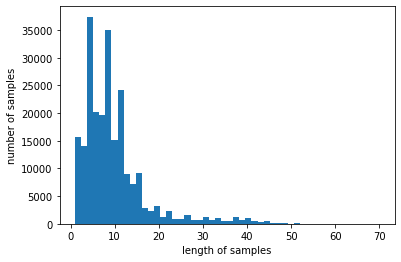

In [54]:
print('리뷰의 최대 길이 :',max(len(review) for review in X_train))
print('리뷰의 평균 길이 :',sum(map(len, X_train))/len(X_train))
plt.hist([len(review) for review in X_train], bins=50)
plt.xlabel('length of samples')
plt.ylabel('number of samples')
plt.show()

In [55]:
def below_threshold_len(max_len, nested_list):
  count = 0
  for sentence in nested_list:
    if(len(sentence) <= max_len):
        count = count + 1
  print('전체 샘플 중 길이가 %s 이하인 샘플의 비율: %s'%(max_len, (count / len(nested_list))*100))

In [56]:
max_len = 30
below_threshold_len(max_len, X_train)

전체 샘플 중 길이가 30 이하인 샘플의 비율: 96.35551658478506


In [64]:
X_train = pad_sequences(X_train, maxlen=max_len)
X_test = pad_sequences(X_test, maxlen=max_len)

# padding = 'post'로 하면 뒤에 0이 붙는다.

In [62]:
print(X_train[:3])

[[   0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0  372  369   27  315  352 2105
     5    1]
 [   0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0   32   26  992    8   58 3061   20 1162  138  246
     6  335]
 [   0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0  745  401    8  256    3  349
  1529  109]]
